# Course Review Sentiment Analysis with Naive Bayes Classifier

This notebook aims to perform sentiment analysis on course reviews using a Naive Bayes classifier. The dataset consists of reviews for various online courses, along with their ratings. The goal is to predict whether a review is positive or negative based on its textual content.

## Steps Taken:

1. **Data Loading and Exploration:**
   - Load the dataset containing course reviews.
   - Explore the data to understand its structure and contents.

2. **Data Preprocessing:**
   - Clean and normalize the text data by removing punctuation, special characters, and digits.
   - Handle missing values and perform basic data transformations.

3. **Exploratory Data Analysis (EDA):**
   - Analyze the distribution of review ratings.
   - Explore the relationship between review ratings and review lengths.

4. **Text Processing:**
   - Tokenize the text data and convert it into numerical features using TF-IDF vectorization.
   - Split the dataset into training and testing sets.

5. **Model Building:**
   - Implement a Multinomial Naive Bayes classifier.
   - Train the classifier on the training data.

6. **Model Evaluation:**
   - Test the performance of the trained model on the testing data.
   - Evaluate the model using classification metrics such as precision, recall, and F1-score.
   - Visualize the performance using a confusion matrix.

7. **Handling Class Imbalance:**
   - Address the imbalance in the dataset by upsampling the minority class.
   - Retrain the model on the upsampled data and evaluate its performance.

8. **Binary Classification:**
   - Convert the multi-class classification problem into a binary classification problem (good vs. bad reviews).
   - Train and evaluate the binary classifier using the same steps as before.

9. **Handling Class Imbalance (Binary Classification):**
   - Upsample the minority class in the binary classification dataset.
   - Retrain the binary classifier on the upsampled data and evaluate its performance.


Relevant Imports

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import string
import re
import pandas as pd
from matplotlib import pyplot as plt
from typing import Sequence, Optional
import numpy as np
import seaborn as sns
sns.set_theme('notebook')

Functions for cleaning text and plotting histogram

In [3]:
# Function for cleaning and normalizing text:

def clean_text(text: str) -> str:
    """
    Clean and normalize the input text by performing the following steps:
    1. Convert the text to lowercase.
    2. Remove punctuation marks from the text.
    3. Remove special characters, punctuation, and digits from the text.
    4. Replace multiple consecutive whitespaces with a single whitespace.

    Parameters:
    - text (str): The input text to be cleaned.

    Returns:
    - str: The cleaned and normalized text.

    Example:
    >>> clean_text("Hello! This is a sample text. It contains special characters & digits 123.")
    'hello this is a sample text it contains special characters digits'
    """
    text = text.lower()
    text = text.translate(str.maketrans('','',string.punctuation)) # Removes any punctuations present in the text
    text = re.sub(r'^[a-zA-Z]\s', '', text) # Removes special characters, punctuations and digits
    text = re.sub(r'\s+', '', text) # Removes extra whitespaces
    return text

# A function to plot histogram with defined parameters pre calculated
def plot_histogram(data: Sequence, x_label: str, y_label: str, title: str, n_bins: Optional[int] = None) -> None:
    """
    Plot a histogram of the input data with specified parameters.

    Parameters:
    - data (Sequence): The input data for which the histogram will be plotted.
    - x_label (str): The label for the x-axis.
    - y_label (str): The label for the y-axis.
    - title (str): The title of the histogram plot.
    - n_bins (Optional[int]): The number of bins for the histogram. If not provided, 
      it is calculated based on the Freedman-Diaconis rule.

    Returns:
    - None

    Example:
    >>> import numpy as np
    >>> import matplotlib.pyplot as plt
    >>> data = np.random.normal(loc=0, scale=1, size=1000)
    >>> plot_histogram(data, x_label="Value", y_label="Frequency", title="Histogram of Data")
    """
    if n_bins is None:
        n = len(data)
        q3, q1 = np.percentile(data, [75, 25])
        iqr = q3 - q1
        bin_width = 2 * iqr * (n**(-1/3))
        if np.isinf(bin_width) or np.isnan(bin_width) or bin_width == 0:
            n_bins = np.ceil(2*(np.cbrt(n))).astype('int32')
        else:
            data_range = max(data) - min(data)
            n_bins = np.ceil(data_range/bin_width).astype('int32')
    plt.hist(x= data, bins= n_bins)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.tight_layout()
    plt.show()

Get the data

In [4]:
data_file = 'user_courses_review_test_set.csv'
data = pd.read_csv(data_file)
data.head()

,course_name,lecture_name,review_rating,review_comment
0,Advanced Microsoft Excel,F1 to F12 - Using Excel's Function Keys,5,perfect
1,Agile and Scrum Project Management,Agile vs Waterfall - Conclusions,1,The SCRUM chapter are full of errors
2,AI Applications for Business Success,Correlation vs. Causation,3,Bad quality of audio and narrative
3,AI Applications for Business Success,Correlation vs. Causation,3,I need documentation about lecture.
4,Building a 3-Statement Model in Excel,Calculating Cash Flows and Completing the Mode...,5,Great course! Ned has a talent for explaining ...


perform EDA

In [5]:
# check data type:
data['review_rating'] = data['review_rating'].astype(np.float64)
data_types = data.dtypes

# find the missing values:
missing_values = data.isnull().sum()
missing_values, data_types


(course_name       0
 lecture_name      0
 review_rating     0
 review_comment    4
 dtype: int64,
 course_name        object
 lecture_name       object
 review_rating     float64
 review_comment     object
 dtype: object)

In [6]:
review_rating_stats = data['review_rating'].describe()
review_rating_stats

count    154.000000
mean       4.642857
std        0.805849
min        1.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: review_rating, dtype: float64

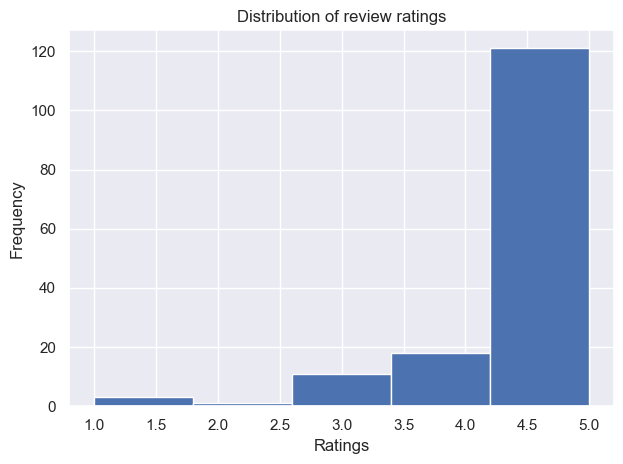

In [7]:
plot_histogram(data['review_rating'], 'Ratings', 'Frequency', 'Distribution of review ratings', 5)

preprocessing

In [8]:
cleaned_data = data.dropna()
new_shape = cleaned_data.shape

cleaned_data['comment_length'] = cleaned_data['review_comment'].apply(len)
correlation = cleaned_data[['review_rating', 'comment_length']].corr()

new_shape, correlation

C:\Users\jadia\AppData\Local\Temp\ipykernel_14580\1371462421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['comment_length'] = cleaned_data['review_comment'].apply(len)


((150, 4),
                 review_rating  comment_length
 review_rating        1.000000       -0.145206
 comment_length      -0.145206        1.000000)

In [9]:
patterns = {
    "positive_emphasis" : re.compile(r'\b(great|good|excellent|amazing|love|best|awesome|fantastic)\b', re.IGNORECASE),
    "negative_emphasis" : re.compile(r'\b(bad|terrible|aweful|poor|worst|hate|dissappoint)\b', re.IGNORECASE),
    "question" : re.compile(r'\?'),
    "exclamation" : re.compile(r'!'),
    "capital_words" : re.compile(r'\b[A-Z]{2,}\b'),
}

pattern_counts = {key: 0 for key in patterns}

for review in cleaned_data['review_comment']:
    for key, pattern in patterns.items():
        if re.search(pattern, review):
            pattern_counts[key] += 1

pattern_counts

{'positive_emphasis': 82,
 'negative_emphasis': 1,
 'question': 0,
 'exclamation': 20,
 'capital_words': 9}

Normalize text comments and split them into training and test sets

In [10]:
cleaned_data.loc[:,'review_comment'] = cleaned_data.loc[:,'review_comment'].apply(clean_text)


# Separation of concerns into features(X) and targets(y):
X = cleaned_data.loc[:, 'review_comment']
y = cleaned_data.loc[:, 'review_rating']

# Split into train and test data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Tokenize, Vectorize and create a model

In [13]:
vectorizer = TfidfVectorizer(stop_words='english')
model = MultinomialNB()

text_clf = make_pipeline(vectorizer, model)
text_clf.fit(X_train, y_train)

y_pred = text_clf.predict(X_test)
report = classification_report(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

print(conf_mat, "\n",report)

[[ 0  0  0  1]
 [ 0  0  0  2]
 [ 0  0  0  4]
 [ 0  0  0 23]] 
               precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         4
         5.0       0.77      1.00      0.87        23

    accuracy                           0.77        30
   macro avg       0.19      0.25      0.22        30
weighted avg       0.59      0.77      0.67        30



C:\Users\jadia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jadia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jadia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classificati